In [31]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Get file path
file_path = '/content/drive/MyDrive/Projects/bankruptcy_prediction_project/american_bankruptcy.dta'

# Load DTA
import pandas as pd
df = pd.read_stata(file_path)

# Preview data
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X13,X14,X15,X16,X17,X18,company_id,log_currentassets,log_currentliabilities,X14_X8
0,C_1020,failed,1999,139.952,345.010,14.354,61.189,6.103,31.061,20.090,...,61.189,44.686,95.088,406.199,63.006,345.010,C_1020,4.941299,3.799660,10358.384766
1,C_1020,failed,2000,156.740,393.287,17.768,46.516,8.046,19.784,35.771,...,46.516,46.566,114.872,439.803,59.053,393.287,C_1020,5.054588,3.840871,10510.132812
2,C_1020,failed,2001,162.621,339.368,19.772,21.378,7.600,7.810,41.202,...,77.545,44.781,122.661,416.913,52.482,395.535,C_1020,5.091423,3.801784,8080.695801
3,C_1020,failed,2002,166.144,370.384,18.838,27.466,8.459,4.329,40.682,...,86.496,62.675,127.127,456.880,69.465,429.414,C_1020,5.112855,4.137963,7041.836914
4,C_1020,failed,2003,175.793,367.841,17.144,21.267,8.664,4.673,28.453,...,81.238,76.057,131.730,449.079,82.391,427.812,C_1020,5.169307,4.331483,14380.857422


In [19]:
df = df[df['status_label'] == 'failed'].copy()

# Rename columns to cleaner format
df.rename(columns={
    'log_currentassets': 'log_current_assets',
    'log_currentliabilities': 'log_current_liabilities'
}, inplace=True)

# Drop missing rows
df = df.dropna(subset=['log_current_assets', 'log_current_liabilities'])

# Confirm it's working
print(df.shape)
print(df[['log_current_assets', 'log_current_liabilities']].describe())

(5219, 25)
       log_current_assets  log_current_liabilities
count         5219.000000              5219.000000
mean             4.099668                 3.751416
std              2.201689                 2.063068
min             -6.907755                -5.298317
25%              2.728408                 2.303934
50%              4.328296                 3.759128
75%              5.594793                 5.078028
max              9.714021                 9.760252


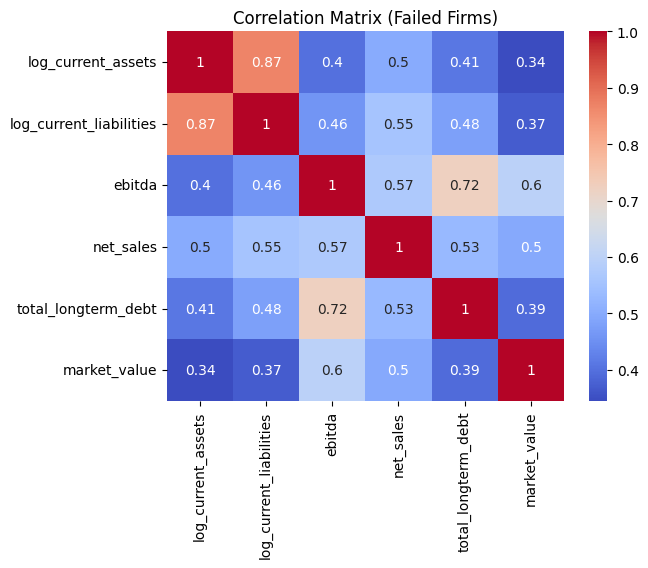

In [23]:
# Rename remaining columns and run the heatmap
df.rename(columns={
    'X4': 'ebitda',
    'X8': 'market_value',
    'X9': 'net_sales',
    'X11': 'total_longterm_debt'
}, inplace=True)

sns.heatmap(
    df[['log_current_assets', 'log_current_liabilities', 'ebitda', 'net_sales', 'total_longterm_debt', 'market_value']].corr(),
    annot=True,
    cmap='coolwarm'
)
plt.title('Correlation Matrix (Failed Firms)')
plt.show()

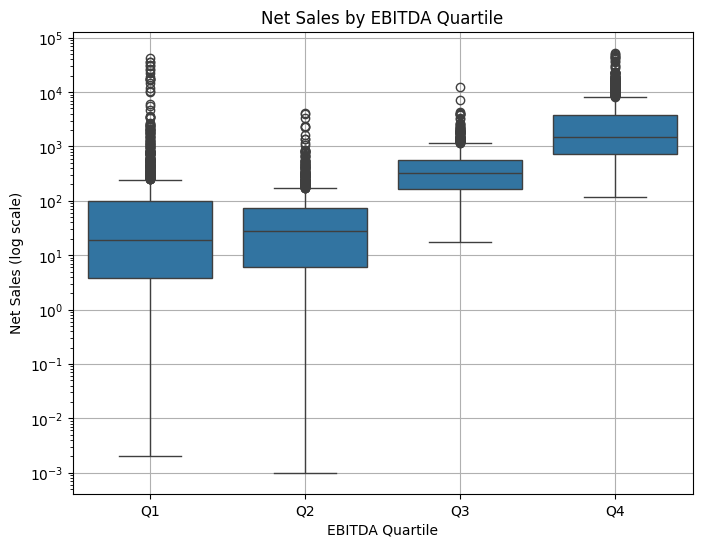

In [27]:
# Boxplot of Net Sales by EBITDA Quartile
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='ebitda_quartile', y='net_sales')
plt.yscale('log')
plt.title('Net Sales by EBITDA Quartile')
plt.xlabel('EBITDA Quartile')
plt.ylabel('Net Sales (log scale)')
plt.grid(True)
plt.show()

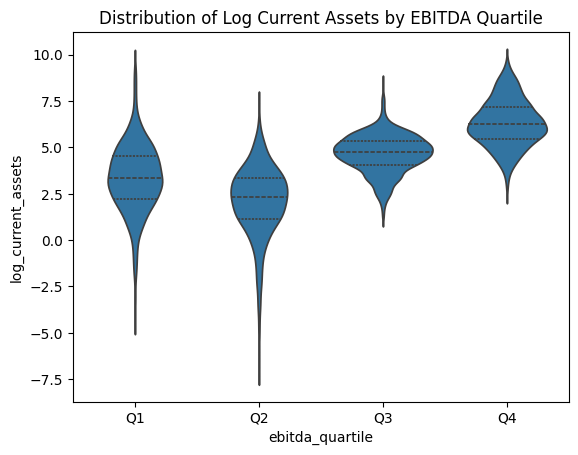

In [38]:
# Violin Plot for Distribution of Log Assets by EBITDA Quartile
sns.violinplot(data=df, x='ebitda_quartile', y='log_current_assets', inner='quartile')
plt.title("Distribution of Log Current Assets by EBITDA Quartile")
plt.show()

In [24]:
# Drop rows with missing values in required variables
df = df.dropna(subset=['log_current_assets', 'log_current_liabilities', 'market_value'])

# Create squared term for polynomial regression
df['log_current_liabilities2'] = df['log_current_liabilities'] ** 2

# Interaction term (optional, includes market context)
df['liab_market_interaction'] = df['log_current_liabilities'] * df['market_value']

# Run OLS regression model
model = smf.ols(
    'log_current_assets ~ log_current_liabilities + log_current_liabilities2 + liab_market_interaction',
    data=df
).fit()

# Display summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     log_current_assets   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     5304.
Date:                Wed, 07 May 2025   Prob (F-statistic):               0.00
Time:                        22:58:09   Log-Likelihood:                -7873.0
No. Observations:                5219   AIC:                         1.575e+04
Df Residuals:                    5215   BIC:                         1.578e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

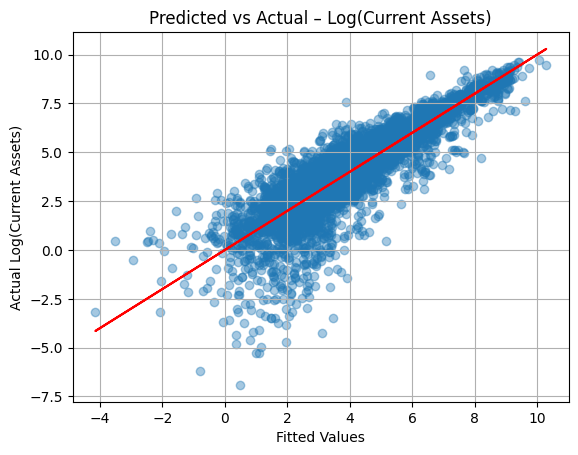

In [26]:
# Predicted vs Actual Plot
plt.scatter(model.fittedvalues, df['log_current_assets'], alpha=0.4)
plt.plot(model.fittedvalues, model.fittedvalues, color='red')  # y=x line
plt.xlabel('Fitted Values')
plt.ylabel('Actual Log(Current Assets)')
plt.title('Predicted vs Actual – Log(Current Assets)')
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


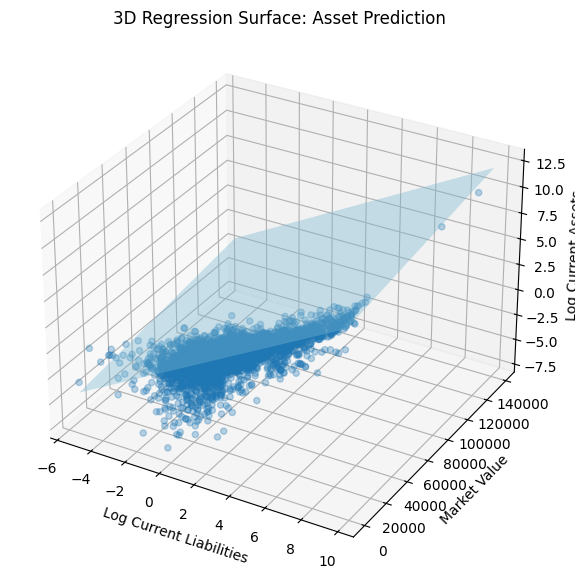

In [28]:
# 3D Regression Surface Plot

# Drop NAs and get variables
subset = df[['log_current_liabilities', 'market_value', 'log_current_assets']].dropna()
X = subset[['log_current_liabilities', 'market_value']]
y = subset['log_current_assets']

# Fit model
reg = LinearRegression().fit(X, y)
x_surf, y_surf = np.meshgrid(
    np.linspace(X.iloc[:,0].min(), X.iloc[:,0].max(), 50),
    np.linspace(X.iloc[:,1].min(), X.iloc[:,1].max(), 50)
)
z_surf = reg.predict(np.column_stack([x_surf.ravel(), y_surf.ravel()])).reshape(x_surf.shape)

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X.iloc[:,0], X.iloc[:,1], y, alpha=0.3)
ax.plot_surface(x_surf, y_surf, z_surf, color='skyblue', alpha=0.4)
ax.set_xlabel('Log Current Liabilities')
ax.set_ylabel('Market Value')
ax.set_zlabel('Log Current Assets')
ax.set_title('3D Regression Surface: Asset Prediction')
plt.show()